# Baseline

In [1]:
import torch
from PIL import Image
from torchvision.transforms import v2
import torchvision.transforms as v1
from torch import nn
import numpy as np
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from surface_dice import SurfaceDiceMetric
import wandb

device = "cuda" if torch.cuda.is_available() else "cpu"
input_dir = "/kaggle/input/blood-vessel-segmentation/"
train_dir = input_dir + "train/"

# reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load data

### Dataset

In [2]:
class KidneyDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_dir, msks_dir, slices_ids, transform=None, target_transform=None):
        self.imgs_dir = imgs_dir
        self.msks_dir = msks_dir
        self.slices_ids = slices_ids
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.slices_ids)
    
    def __getitem__(self, idx):
        slice_id = self.slices_ids[idx]
        img_path = self.imgs_dir + slice_id
        msk_path = self.msks_dir + slice_id

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform is not None:
            # Don't use to_tensor() because dtype conversion disturbs the distribution
            img = torch.from_numpy(np.array(img, dtype=np.float32))[None, :, :]
            img = self.transform(img)
            img = img / img.max()

        if self.target_transform is not None:
            msk = self.target_transform(msk).squeeze()

        return img, msk

In [3]:
h_resize, w_resize = 224, 224

imgs_dir = f"{train_dir}kidney_1_dense/images/"
msks_dir = f"{train_dir}kidney_1_dense/labels/"
slices_ids = sorted(os.listdir(imgs_dir))

transform = v2.Compose([
    v2.Resize(size=(h_resize, w_resize), antialias=True),
])
target_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize(size=(h_resize, w_resize), interpolation=v2.InterpolationMode.NEAREST, antialias=True),
    v2.ToDtype(torch.float32, scale=True),
])

ds = KidneyDataset(imgs_dir=imgs_dir, msks_dir=msks_dir, slices_ids=slices_ids, transform=transform, target_transform=target_transform)

print("Dataset length:", len(ds))

Dataset length: 2279


In [4]:
bs = 32
num_workers = os.cpu_count()
train_dl = DataLoader(ds, batch_size=bs, num_workers=num_workers, shuffle=False, persistent_workers=True)
print("DataLoader length:", len(train_dl))

DataLoader length: 72


## Define model

In [5]:
import segmentation_models_pytorch as smp

net = smp.Unet(
    encoder_name="timm-mobilenetv3_small_075",
    encoder_weights=None,
    in_channels=1,
    classes=1,
)
print(f"Number of params: {sum([p.nelement() for p in net.parameters()]):,}")

Number of params: 2,881,625


In [6]:
net.to(device);

## Train model

### Loss function

#### Test loss function

In [7]:
x = torch.randn((16, 512, 512))
y = torch.randint(2, (16, 512, 512), dtype=torch.float32)

In [8]:
print(torch.nn.functional.binary_cross_entropy_with_logits(x, y))
print(torch.nn.functional.binary_cross_entropy_with_logits(x, y, pos_weight=torch.tensor(3)))
print(torch.nn.functional.binary_cross_entropy_with_logits(x, y, pos_weight=torch.tensor([3])))
print(torch.nn.functional.binary_cross_entropy_with_logits(x, y, pos_weight=torch.tensor([3]).view(1, 1)))


tensor(0.8061)
tensor(1.6113)
tensor(1.6113)
tensor(1.6113)


In [9]:
print(-torch.where(y == 1, x.sigmoid().log(), (1 - x.sigmoid()).log()).mean())
print(-torch.where(y == 1, 3*x.sigmoid().log(), (1 - x.sigmoid()).log()).mean())

tensor(0.8061)
tensor(1.6113)


#### Determine positive weight

In [10]:
total = 0
pos = 0
for _, y in tqdm(train_dl):
    total += y.nelement()
    pos += y.sum().long().item()

pos_weight = total/pos - 1
pos_weight

100%|██████████| 72/72 [00:20<00:00,  3.51it/s]


161.06015512840682

In [11]:
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))

### Optimizer and scheduler

In [12]:
lr = 3e-4
optimizer = torch.optim.Adam(lr=lr, params=net.parameters())

### Train method

In [13]:
def train():
    train_loss = 0.0
    net.train()
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        logits = net(x).squeeze() 
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = torch.where(logits.detach().sigmoid() >= 0.5, 1, 0)
        train_loss += loss.item()

    train_loss /= len(train_dl)

    return train_loss

### Eval method

In [14]:
@torch.no_grad()
def eval(dl):
    eval_loss = 0.0
    net.train()  # TODO: Put in eval mode
    metric = SurfaceDiceMetric(n_batches=len(dl), device=device)
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        logits = net(x).squeeze() 
        loss = loss_fn(logits, y)

        pred = torch.where(logits.sigmoid() >= 0.5, 1, 0)
        metric.process_batch(pred, y)
        eval_loss += loss.item()

    eval_loss /= len(dl)
    surface_dice = metric.compute()

    return eval_loss, surface_dice

In [15]:
epochs = 10
losses = []
dices = []

for epoch in range(epochs):
    train_loss = train()
    eval_loss, surface_dice = eval(train_dl)
    print(f"EPOCH {epoch}, DICE {surface_dice:.4f} TLOSS {train_loss:.4f}, ELOSS {eval_loss:.4f}")
    losses.append(train_loss)
    dices.append(surface_dice)

EPOCH 0, DICE 0.0456 TLOSS 0.8422, ELOSS 0.8447
EPOCH 1, DICE 0.0554 TLOSS 0.6255, ELOSS 0.7085
EPOCH 2, DICE 0.1100 TLOSS 0.5503, ELOSS 0.6903
EPOCH 3, DICE 0.1351 TLOSS 0.4913, ELOSS 0.7627
EPOCH 4, DICE 0.1346 TLOSS 0.4526, ELOSS 0.6148
EPOCH 5, DICE 0.1406 TLOSS 0.4178, ELOSS 0.5274
EPOCH 6, DICE 0.1497 TLOSS 0.3870, ELOSS 0.5154
EPOCH 7, DICE 0.1611 TLOSS 0.3554, ELOSS 0.4901
EPOCH 8, DICE 0.1804 TLOSS 0.3311, ELOSS 0.4157
EPOCH 9, DICE 0.1496 TLOSS 0.3050, ELOSS 0.3623


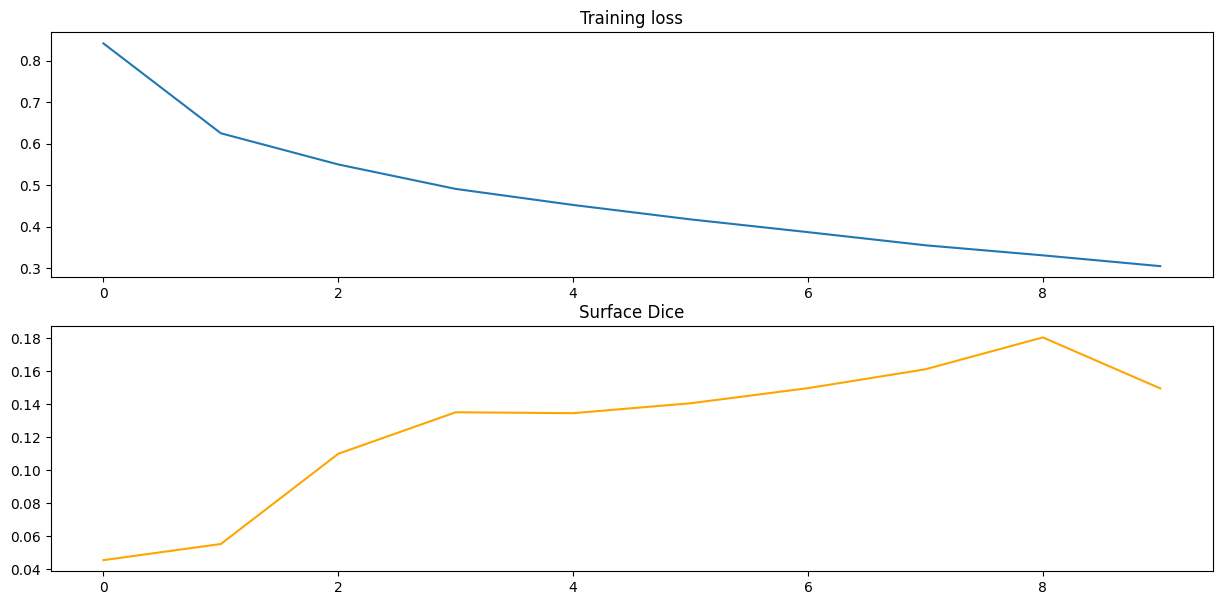

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(15, 7))
axs[0].set_title("Training loss")
axs[1].set_title("Surface Dice")
axs[0].plot(losses)
axs[1].plot(dices, color="orange")
plt.show()

## Inference on train dataset

In [17]:
x, y = next(iter(train_dl))
x = x.cuda()
probs = net(x).squeeze().detach().sigmoid().cpu()
print(f"loss with pos_weight: {torch.nn.functional.binary_cross_entropy_with_logits(net(x).squeeze().detach().cpu(), y, pos_weight=torch.tensor(pos_weight)).item():.5f}")
print(f"loss without pos_weight: {torch.nn.functional.binary_cross_entropy_with_logits(net(x).squeeze().detach().cpu(), y).item():.5f}")

loss with pos_weight: 0.09070
loss without pos_weight: 0.09070


9


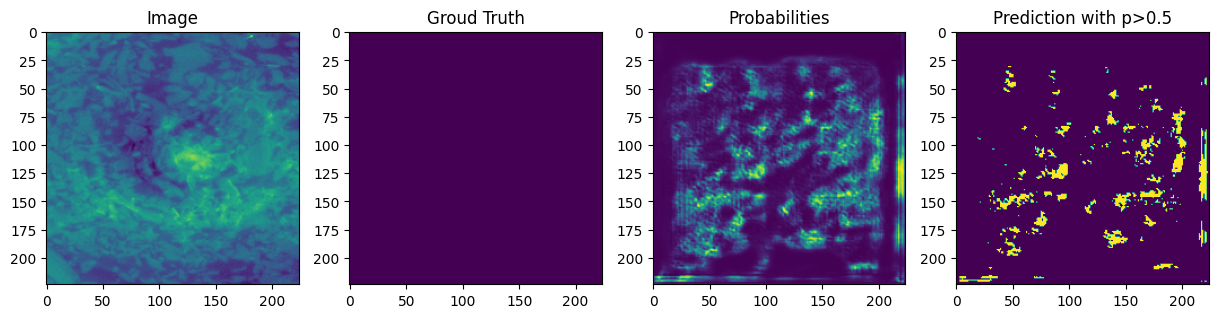

In [18]:
idx = torch.randint(bs, (1,)).item()
threshold = 0.5
print(idx)

fig, axs = plt.subplots(1, 4, figsize=(15, 7))
axs[0].set_title("Image")
axs[1].set_title("Groud Truth")
axs[2].set_title("Probabilities")
axs[3].set_title(f"Prediction with p>{threshold}")
axs[0].imshow(x.cpu()[idx].squeeze())
axs[1].imshow(y[idx])
axs[2].imshow(probs[idx])
axs[3].imshow(torch.where(probs >= threshold, 1, 0)[idx])
plt.show()